# Import

In [1]:
import types
from itertools import islice
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from IPython.core.debugger import set_trace
from PIL import Image
from torch.utils.data import DataLoader

from fiducial_detect.data import *
from fiducial_detect.models import *

# Utility

In [2]:
def save_checkpoint(model, optimizer, metrics, file_checkpoint):
    torch.save({'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'metrics': metrics},
               file_checkpoint)

In [3]:
def load_checkpoint(model, optimizer, file_checkpoint):
    checkpoint = torch.load(file_checkpoint)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    metrics = checkpoint['metrics']
    return model, optimizer, metrics

In [4]:
def train(model, dl, loss, metrics, optimizer, device):
    m, total_items = dict.fromkeys(metrics.keys(), 0), 0
    
    # Train for an epoch
    model.train()
    for X, y in dl:
        X, y = X.to(device), y.to(device)
        
        # Optimize
        optimizer.zero_grad()
        y_hat = model(X)
        l = loss(y_hat, y)
        l.backward()
        optimizer.step()
        
        # Get metrics scaled by batch size
        for key, metric in metrics.items():
            m[key] += metric(y_hat, y)*X.shape[0] # Scale by batch size
           
        # Track total number of items
        total_items += X.shape[0]
        
    # Get mean of metrics
    for key, metric in metrics.items():
        m[key] /= total_items
        
    return m

In [5]:
def validate(model, dl, loss, metrics, optimizer, device):
    m, total_items = dict.fromkeys(metrics.keys(), 0), 0
    
    # Validate
    model.eval()
    with torch.no_grad():
        for X, y in dl:
            X, y = X.to(device), y.to(device)

            y_hat = model(X)

            # Get metrics scaled by batch size
            for key, metric in metrics.items():
                m[key] += metric(y_hat, y)*X.shape[0] # Scale by batch size

            # Track total number of items
            total_items += X.shape[0]

        # Get mean of metrics
        for key, metric in metrics.items():
            m[key] /= total_items

    return m

# Metrics

In [6]:
class MetricAccuracy():
    def __call__(self, y_hat, y):
        return (y_hat.argmax(dim=1) == y).float().mean().item()

# Train

In [7]:
# Config
batch_size = 32
num_workers = 4
pin_memory = True
num_batches = 20
num_epochs = 200
lr = 1e-3
schedule = False

# Device
device = torch.device('cuda')

# Loss
loss = nn.functional.cross_entropy

# Metrics
metrics = {}
metrics['loss'] = lambda y_hat, y: loss(y_hat, y).item()
metrics['acc'] = MetricAccuracy()

# Model
layout_encoder = [[ 1, 32, 5, 2, 2],
                  [32, 32, 3, 2, 1],
                  [32, 32, 3, 2, 1],
                  [32, 32, 3, 2, 1]]
model = UNET(get_encoder(layout_encoder), 5)
model = model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [8]:
tfms_trn = Compose([Resize((512, 384)), 
                    Normalize((0, 1), (-1, 1)),
                    RandomContrast((0.5, 1.5), 1, 0.5),
                    RandomBrightness((-1.0, 0.5), -0.25, 0.5),
                    RandomBlur((0, 1.5), 0.75, 0.5),
                    Noise((-0.1, 0.1), 0, 0.1),
                    RandomGrad((-0.5, 0.5)),
                    Clip((-1,1)),
                    ToTensor()])

dl_trn = IsliceDataloader(num_batches,
                          SyntheticMaskDataSet(tfms=tfms_trn), 
                          batch_size=batch_size,
                          num_workers=num_workers,
                          pin_memory=pin_memory, 
                          worker_init_fn=lambda wid: np.random.seed(np.mod(torch.initial_seed() + wid, 2**32)))

In [9]:
tfms_val = Compose([Resize((512, 384)), 
                    Normalize((0, 1), (-1, 1)),
                    ToTensor()])

dl_val = DataLoader(RealMaskDataSet(Path('data'), tfms=tfms_val), 
                    batch_size=batch_size,
                    num_workers=num_workers,
                    pin_memory=pin_memory, 
                    worker_init_fn=lambda wid: np.random.seed(np.mod(torch.initial_seed() + wid, 2**32)))

<IPython.core.display.Javascript object>


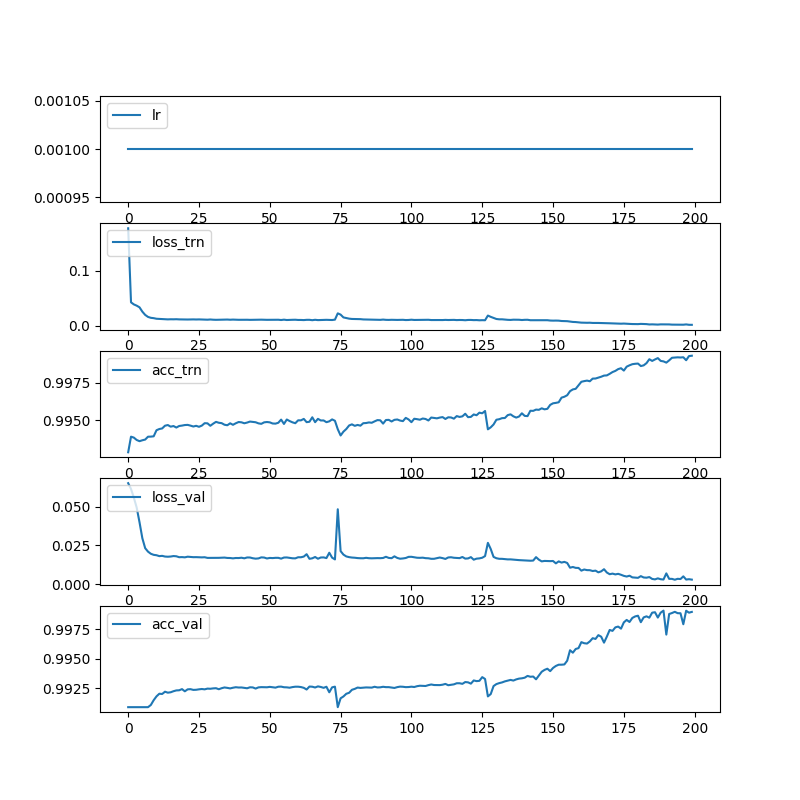

            lr   loss_trn    acc_trn   loss_val    acc_val
0      0.00100    0.17678    0.99283    0.06499    0.99091
1      0.00100    0.04259    0.99388    0.06124    0.99091
2      0.00100    0.03882    0.99382    0.05569    0.99091
3      0.00100    0.03657    0.99366    0.04932    0.99091
4      0.00100    0.03355    0.99358    0.03990    0.99091
5      0.00100    0.02572    0.99364    0.02964    0.99091
6      0.00100    0.01981    0.99369    0.02325    0.99091
7      0.00100    0.01617    0.99388    0.02102    0.99091
8      0.00100    0.01453    0.99389    0.01965    0.99110
9      0.00100    0.01391    0.99391    0.01896    0.99151
10     0.00100    0.01283    0.99432    0.01871    0.99183
11     0.00100    0.01253    0.99440    0.01813    0.99205
12     0.00100    0.01234    0.99444    0.01831    0.99203
13     0.00100    0.01196    0.99462    0.01786    0.99222
14     0.00100    0.01171    0.99467    0.01775    0.99214
15     0.00100    0.01190    0.99456    0.01788    0.992

138    0.00100    0.01101    0.99524    0.01557    0.99333
139    0.00100    0.01054    0.99546    0.01545    0.99336
140    0.00100    0.01091    0.99528    0.01528    0.99341
141    0.00100    0.01099    0.99527    0.01520    0.99356
142    0.00100    0.01019    0.99563    0.01518    0.99349
143    0.00100    0.01019    0.99562    0.01528    0.99351
144    0.00100    0.01004    0.99571    0.01749    0.99327
145    0.00100    0.01013    0.99569    0.01586    0.99359
146    0.00100    0.01004    0.99579    0.01476    0.99391
147    0.00100    0.01018    0.99573    0.01505    0.99407
148    0.00100    0.01018    0.99576    0.01501    0.99417
149    0.00100    0.00960    0.99603    0.01492    0.99397
150    0.00100    0.00942    0.99613    0.01501    0.99423
151    0.00100    0.00952    0.99616    0.01349    0.99440
152    0.00100    0.00939    0.99620    0.01476    0.99451
153    0.00100    0.00877    0.99651    0.01400    0.99451
154    0.00100    0.00868    0.99657    0.01444    0.994

In [10]:
%matplotlib notebook

# Training loop
df_metrics = pd.DataFrame(columns=['lr'] + 
                                  [str(key+'_trn') for key in metrics.keys()] +
                                  [str(key+'_val') for key in metrics.keys()])
fig, axs = plt.subplots(df_metrics.shape[1], 1, figsize=(8,8))
for num_epoch in range(num_epochs):    
    # Train
    m_trn = train(model, dl_trn, loss, metrics, optimizer, device)
    
    # Validate
    m_val = validate(model, dl_val, loss, metrics, optimizer, device)
    
    # Step scheduler
    if schedule:
        scheduler.step(m_trn['loss'])
    
    # Store metrics
    df_metrics.loc[num_epoch, 'lr'] = np.mean([p['lr'] for p in optimizer.param_groups])
    for key, val in m_trn.items(): df_metrics.loc[num_epoch, key+'_trn'] = val
    for key, val in m_val.items(): df_metrics.loc[num_epoch, key+'_val'] = val

    # Plot stuff
    for idx, key in enumerate(df_metrics.columns):
        axs[idx].clear()
        axs[idx].plot(np.arange(num_epoch+1), df_metrics[key], label=key)
        axs[idx].legend(loc='upper left')
    fig.canvas.draw()
    
    # Print metrics
    print(df_metrics.iloc[[num_epoch]].to_string(header=num_epoch == 0,
                                                 float_format=lambda x: f'{x:10.5f}',
                                                 col_space=3))
    
%matplotlib inline

In [31]:
save_checkpoint(model, optimizer, df_metrics, Path('checkpoints/epoch_200.pth'))

In [140]:
X, y = next(iter(dl_trn))
X, y = X.to(device), y.to(device)

In [141]:
model.eval()
with torch.no_grad():
    y_hat = model(X)

In [142]:
idx = 2

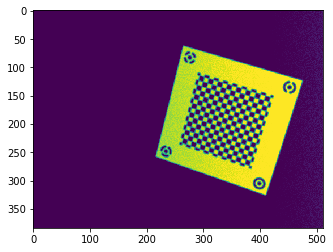

In [143]:
plt.imshow(X[idx,0,:,:].cpu().detach())

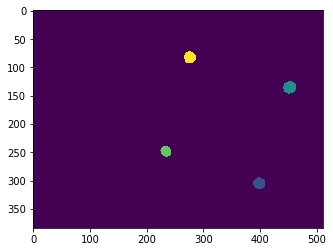

In [144]:
plt.imshow(y_hat.argmax(dim=1).cpu().detach()[idx], vmin=0, vmax=4)

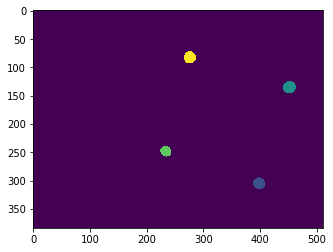

In [145]:
plt.imshow(y.cpu().detach().numpy()[idx], vmin=0, vmax=4)

In [126]:
files_img = [p for p in Path('data').glob('*.png') if not p.name.endswith('mask.png')]

In [127]:
idx = 5
img = Image.open(files_img[idx])

In [128]:
img = img.resize((512, 384))

In [129]:
img = np.array(img)

In [130]:
img = img.astype(np.float32)

In [131]:
img /= img.max()

In [132]:
img = normalize(img, [0, 1], [-1, 1])

In [133]:
img.min(), img.max()

(-0.9928058, 1.0)

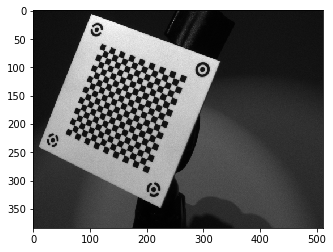

In [134]:
plt.imshow(img, vmin=-1, vmax=1, cmap='gray')

In [135]:
img = torch.tensor(img)[None][None]
img.shape

torch.Size([1, 1, 384, 512])

In [136]:
img = img.to(device)

In [137]:
model.eval()
with torch.no_grad():
    mask = model(img)

In [138]:
mask = mask.argmax(dim=1).cpu().detach().numpy()[0]

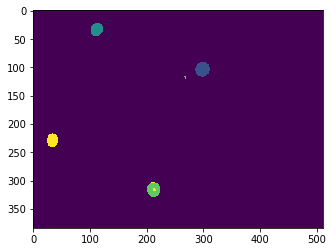

In [139]:
plt.imshow(mask, vmin=0, vmax=4)